In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import xgboost as xgb
import shap

## 1. Student Body diversity

In [131]:
ethnicity = pd.read_csv('IPEDS_Dataset_Encoded/Fall Enrollment/EFA_2015-2020_data.csv', sep=',')

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
invalid value encountered in divide


Text(0, 0.5, 'Count')

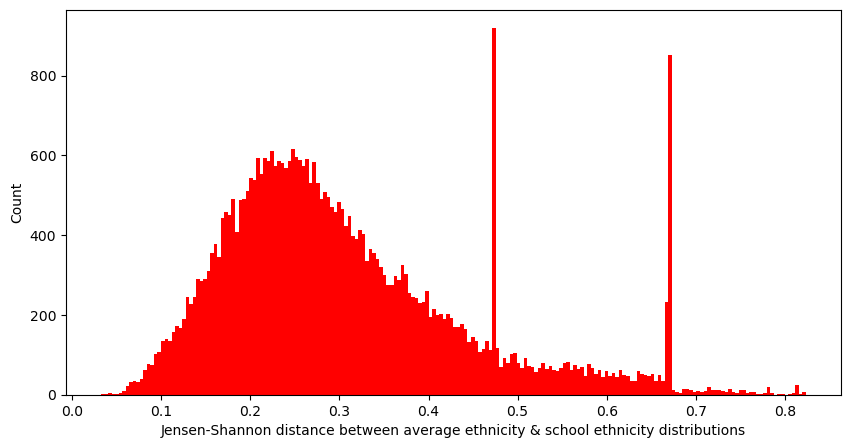

In [132]:
def JSD(b): 
    '''
    Jensen-Shannon distance between two vectors
    '''
    a = overall_ethn
    b = np.array(b, dtype=np.float)
    _M = 0.5 * (a + b)
    return distance.jensenshannon(a,b)

ethn = ethnicity[(ethnicity.efalevel == 'All students total')].set_index('unitid')
ethn.loc[:,'other'] = ethn[['ef2mort',"efunknt","efunknt"]].sum(axis=1)

data_ethn = ethn[['efaiant','efasiat','efbkaat','efhispt','efnhpit','efwhitt','other']].div(ethn['eftotlt'], axis=0)
overall_ethn = np.array(data_ethn.mean())


data_ethn['kl_distance'] = data_ethn.apply(lambda x: JSD(np.array(x)), axis=1)
data_ethn['kl_distance'] = data_ethn['kl_distance'].apply(lambda x: 10 if x==np.inf else x)

fig, ax  = plt.subplots(figsize=(10,5))
data_ethn['kl_distance'].hist(bins=200, color='r').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Jensen-Shannon distance between average ethnicity & school ethnicity distributions')
ax.set_ylabel('Count')

## 2. Graduation rate

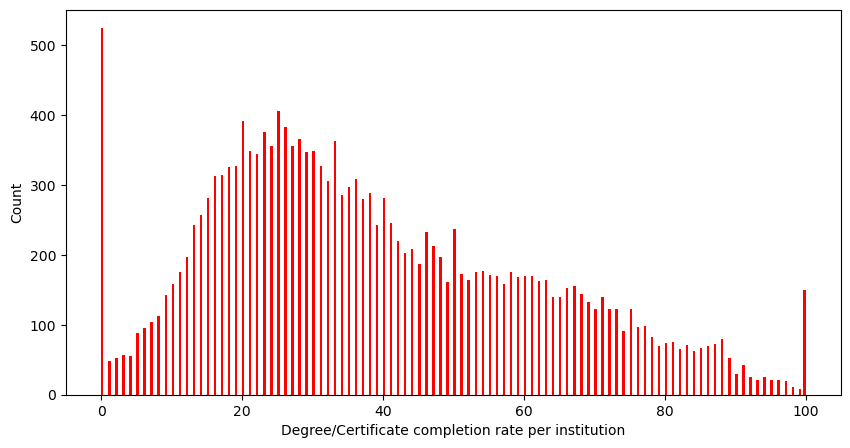

Median completion rate: 34.0%
Mean completion rate: 38.5513900357831%


In [133]:
undergrad_compl = pd.read_csv(r'IPEDS_Dataset_Encoded/Outcome Measures/OM_2015-2021_data.csv', sep=',')
data_compl = undergrad_compl[(undergrad_compl.omchrt == 'First-time, full-time entering, Total')]
fig, ax  = plt.subplots(figsize=(10,5))
data_compl['OMAWDP4'.lower()].hist(bins=300, color='red').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Degree/Certificate completion rate per institution')
ax.set_ylabel('Count')
plt.show()
print('Median completion rate: {}%'.format(data_compl[['OMAWDP4'.lower()]].median().values[0]))
print('Mean completion rate: {}%'.format(data_compl[['OMAWDP4'.lower()]].mean().values[0]))

## 3. Tution fees intensity

In [134]:
fees_money_school = pd.read_csv(r'IPEDS_Dataset_Encoded/Institutional Finances/F_F2_1415-1920_data.csv', sep=',')
fees_money_school[['f2d01','unitid']].groupby('unitid').mean()

,f2d01
unitid,
100690,7.365773e+06
100937,1.391152e+07
101073,2.727705e+06
101189,3.440194e+07
101365,7.459146e+06
...,...
495280,2.716200e+04
495314,6.893088e+06
495767,1.739282e+09


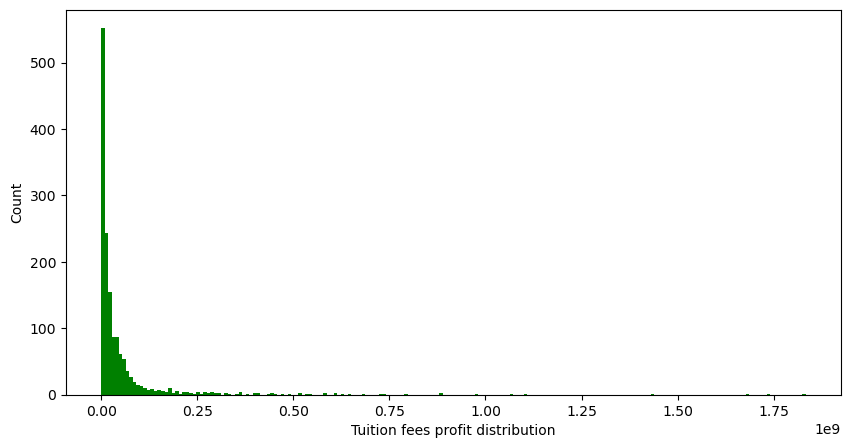

In [135]:
rel_ethn_completion = data_ethn.merge(data_compl[['unitid','OMAWDP4'.lower()]].set_index('unitid'), on='unitid')
rel_ethn_completion = rel_ethn_completion.reset_index().groupby('unitid').mean()

data_without_gpa = rel_ethn_completion.groupby('unitid').first().merge(fees_money_school[['f2d01','unitid']].groupby('unitid').mean(), on='unitid')

stats_df = data_without_gpa.reset_index() \
.groupby('f2d01') \
['f2d01'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'f2d01': 'frequency'})
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pdf'].cumsum()

dico_fee = stats_df['cdf'].to_dict()
data_without_gpa['cdf_fee'] = data_without_gpa['f2d01'].map(dico_fee)

fig,ax = plt.subplots(figsize=(10,5))
data_without_gpa['f2d01'].hist(bins=200, color='green').plot()
ax.grid(False)
ax.set_xlabel('Tuition fees profit distribution')
ax.set_ylabel('Count')
plt.show()



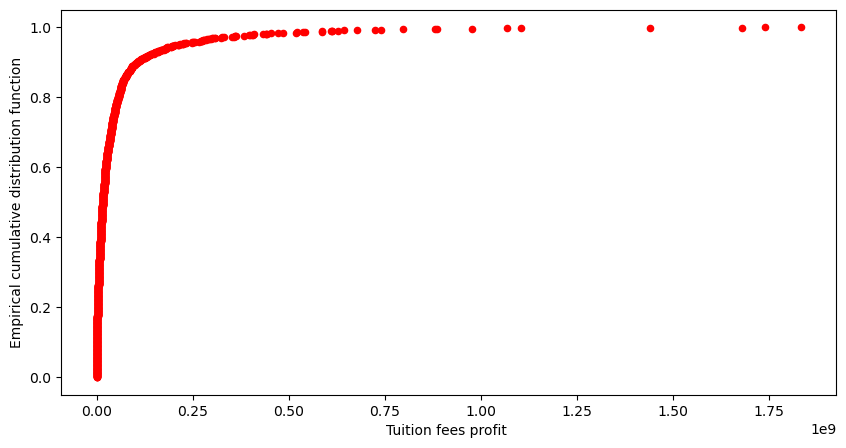

In [136]:
fig,ax = plt.subplots(figsize=(10,5))
data_without_gpa.sort_values(by='cdf_fee').plot.scatter(y='cdf_fee',x='f2d01', ax=ax, color='red')
ax.grid(False)
ax.set_xlabel('Tuition fees profit ')
ax.set_ylabel('Empirical cumulative distribution function')
plt.show()


## 4. Selection rate (approximated by the admission rate)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


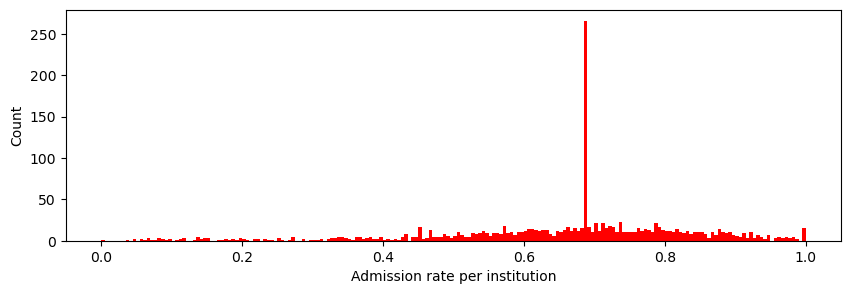

In [137]:
adm_data = pd.read_csv(r'IPEDS_Dataset_Encoded/Admission and Test Scores/ADM_2015-2021_data.csv',sep=',')
nb_appl = pd.DataFrame(adm_data.groupby('unitid').sum()['applcn'])['applcn']
nb_adm = pd.DataFrame(adm_data.groupby('unitid').sum()['admssn'])['admssn']
adm_rate = nb_adm/nb_appl
adm_rate_dico = adm_rate.to_dict()

data_with_level = data_without_gpa.reset_index()
data_with_level['level'] = data_with_level['unitid'].map(adm_rate_dico)
data_with_level = data_with_level.fillna(data_with_level['level'].median()) #fill empty values with the median
data_with_level['omawdp4'] /=100

fig,ax = plt.subplots(figsize=(10,3))
data_with_level['level'].hist(bins=200, color='r').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Admission rate per institution')
ax.set_ylabel('Count')
plt.show()

## 5. School quality indicator


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


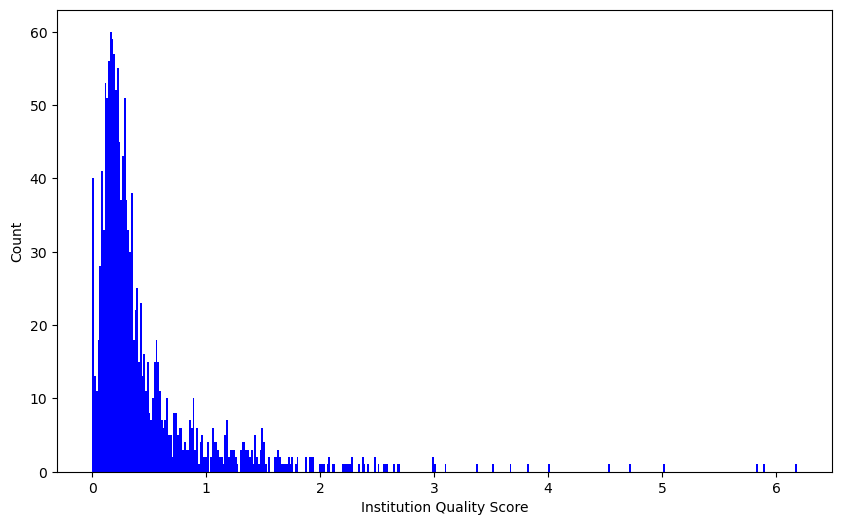

In [138]:
df_final = data_with_level[['kl_distance','omawdp4','cdf_fee','level']]
df_final['school_quality'] = (df_final['kl_distance']*df_final['omawdp4'])/(df_final['cdf_fee']*df_final['level'])

fig,ax = plt.subplots(figsize=(10,6))
df_final['school_quality'].apply(lambda x: np.log(1+x)).hist(bins=400, color='blue').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Institution Quality Score')
ax.set_ylabel('Count')
plt.show()

## 6. Model conception: Parametrization through prediction models

### 6.1. Graduation rate model

Determination score: 0.94


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


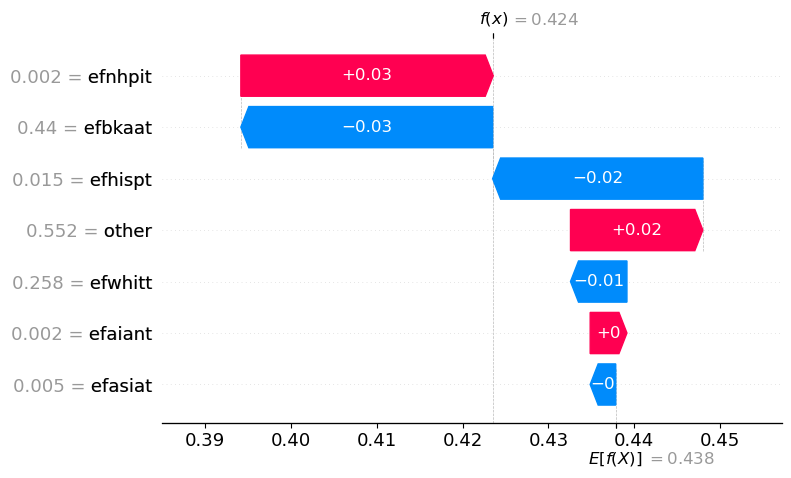

In [139]:
model_grad_rate = xgb.XGBRegressor(objective="reg:squarederror") 

model_grad_rate.fit(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['omawdp4']))

model_grad_rate_viz = xgb.XGBRegressor(objective="reg:squarederror") 
model_grad_rate_viz.fit(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['omawdp4'])
print('Determination score: {}'.format(np.round(model_grad_rate_viz.score(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['omawdp4']),2)))

explainer = shap.Explainer(model_grad_rate_viz)

shap_values = explainer(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']])
shap.plots.waterfall(shap_values[0])

In [140]:
from sklearn.model_selection import train_test_split

X,y=np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['omawdp4'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
model_grad_rate = xgb.XGBRegressor(objective="reg:squarederror" ,max_depth = 5) 

model_grad_rate.fit(X_train, y_train)
print(model_grad_rate.score(X_test, y_test))
                                                    

0.2846745040026508


### 6.2 University level model

Determination score: 0.97


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


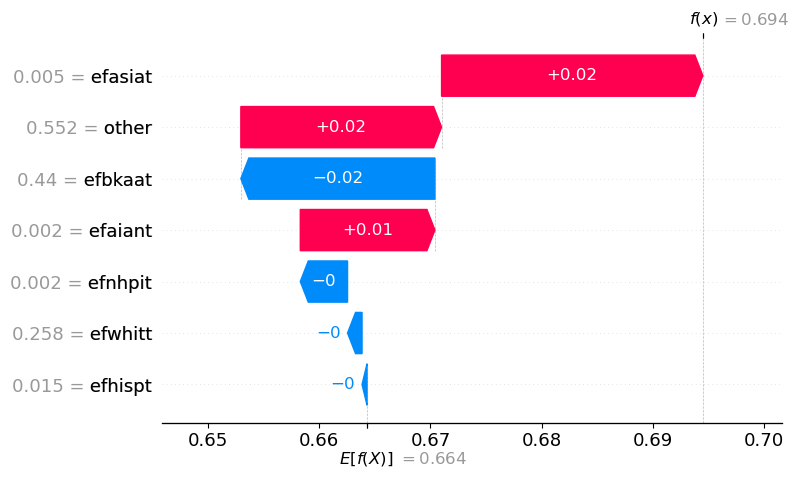

In [141]:
model_level = xgb.XGBRegressor(objective="reg:squarederror") 

model_level.fit(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level']))

print('Determination score: {}'.format(np.round(model_level.score(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level'])),2)))

model_level_viz = xgb.XGBRegressor(objective="reg:squarederror") 
model_level_viz.fit(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['level'])

explainer = shap.Explainer(model_level_viz)

shap_values = explainer(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']])

shap.plots.waterfall(shap_values[0])

In [142]:
X,y=np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_level = xgb.XGBRegressor(objective="reg:squarederror" ,max_depth = 5) 

model_level.fit(X_train, y_train)
print(model_level.score(X_test, y_test))
                                                    

0.043550716265142175


## 7. Parametric postsecondary system effectiveness

In [143]:
list_schools = np.array(data_with_level['unitid'])
dico_school_cdf_fee = data_with_level[['unitid','cdf_fee']].set_index('unitid').to_dict()['cdf_fee']
dico_school_level = data_with_level[['unitid','level']].set_index('unitid').to_dict()['level']
dico_school_grad_rate = data_with_level[['unitid','omawdp4']].set_index('unitid').to_dict()['omawdp4']
#omawdp4

def parametric_institution_quality_school(school, p):
    diversity_score = JSD(p)
    #graduation_rate = model_grad_rate.predict([p])[0]
    graduation_rate = dico_school_grad_rate[school]
    fee_cdf = dico_school_cdf_fee[school]
    #admission_rate = model_level.predict([p])[0]
    admission_rate = dico_school_level[school]
    return (diversity_score*graduation_rate)/(fee_cdf*admission_rate)

def parametric_institution_quality(p_list):
    df = data_with_level.copy()
    df[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']]=p_list
    df['school_quality']=df[['unitid','efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']].apply(
    lambda x: parametric_institution_quality_school(x[0],[x[i] for i in range(1,8)]), axis=1)
    #x[0],[x[i] for i in range(1,8)])
    return df['school_quality'].mean()

def param_quality(p):
    p_list = p.reshape(len(data_with_level),7)
    return -parametric_institution_quality(p_list)

cons = ({'type': 'eq',
         'fun' : lambda x: x[7*i+1]+x[7*i+2]+x[7*i+3]+x[7*i+4]+x[7*i+5]+x[7*i+6] - 1
        } for i in range(len(data_with_level)))


initial_guess = np.ndarray.flatten(
    np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']])
                                    )

In [144]:
print(param_quality(initial_guess))
initial_guess

-1.9420358912826723


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
invalid value encountered in double_scalars


array([0.00233418, 0.00458423, 0.43961975, ..., 0.00081277, 0.63634542,
       0.08335931])

In [145]:
# from scipy.optimize import minimize

# nb_eval = 1
# def callbackF(x):
#     global nb_eval
#     print(nb_eval, param_quality(x))
#     nb_eval += 1
    
# opt_ethn_prop = minimize(param_quality, initial_guess, constraints = cons, options={'maxiter':5}, callback=callbackF)

In [146]:
data_with_level_sorted = data_with_level.sort_values(by = 'level', ascending=True)
data_with_level_sorted

,unitid,efaiant,efasiat,efbkaat,efhispt,efnhpit,efwhitt,other,kl_distance,omawdp4,f2d01,cdf_fee,level
1447,488004,0.000000,0.000000,0.000000,0.000000,0.000000,0.971111,0.000000,0.472110,0.000000,2.354054e+05,0.018767,0.000000
916,211893,0.000000,0.176367,0.046137,0.024705,0.000000,0.362545,0.000000,0.366375,0.342000,7.390003e+05,0.072386,0.038903
1237,243744,0.004571,0.175157,0.041641,0.106657,0.001692,0.341180,0.111658,0.237242,0.746000,4.410792e+08,0.980563,0.046028
447,166027,0.002046,0.138004,0.056549,0.085753,0.001035,0.415491,0.113379,0.201070,0.854000,8.805940e+08,0.994638,0.048649
627,186131,0.001179,0.167909,0.060058,0.084914,0.000892,0.385770,0.105506,0.221821,0.890000,1.176000e+08,0.909517,0.058247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,488101,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.472110,0.183333,1.053861e+06,0.102547,1.000000
887,209108,0.006452,0.032077,0.040758,0.070582,0.003044,0.657251,0.305648,0.242141,0.080000,1.260806e+07,0.443700,1.000000
757,197610,0.000000,0.000000,0.000000,0.060606,0.000000,0.820988,0.000000,0.438369,0.210000,1.224865e+06,0.115282,1.000000
718,194718,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.472110,0.000000,4.359770e+05,0.041555,1.000000



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1492, 7)
(1492, 7)


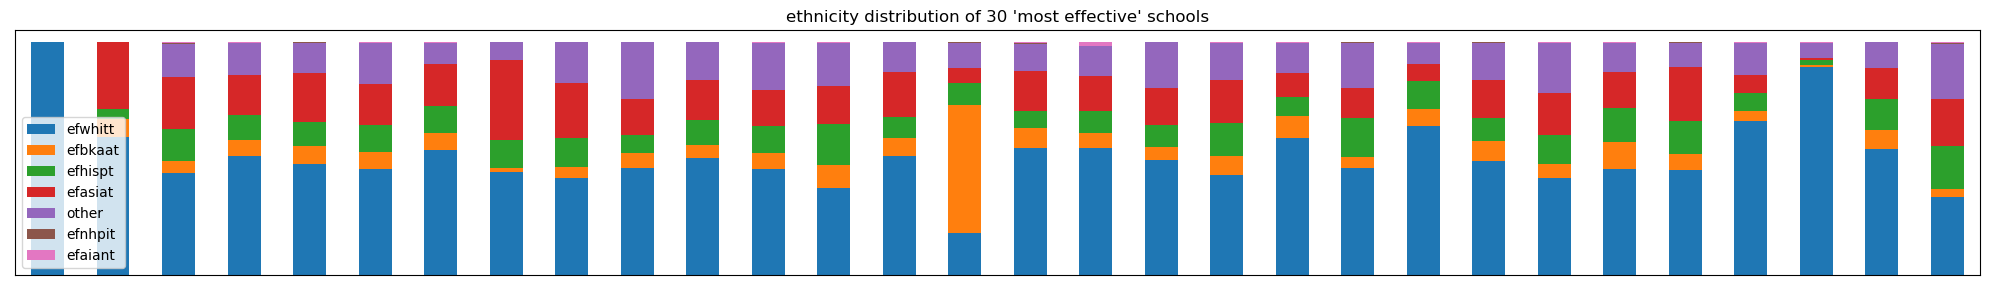

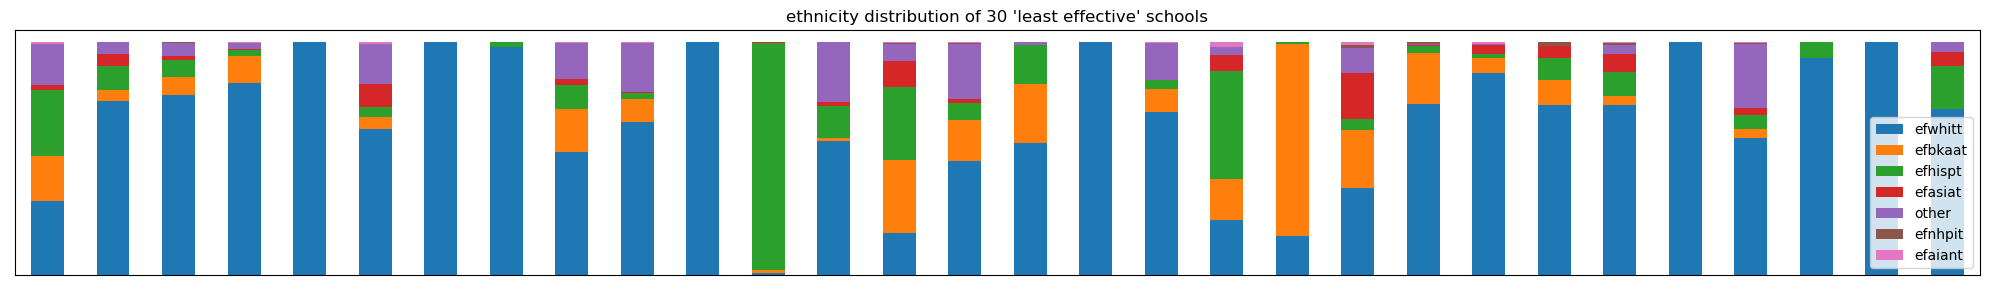

In [147]:
ethn_list = ['efwhitt', 'efbkaat', 'efhispt', 'efasiat','other', 'efnhpit',  'efaiant']

final_ethn = data_with_level_sorted[ethn_list]

#ax =plt.axes()

final_ethn[ethn_list]=final_ethn[ethn_list].div(final_ethn[ethn_list].sum(axis=1), axis=0)




ax = final_ethn.head(30).plot(kind='bar', stacked=True,
                             align='edge', figsize=(20, 3),)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text("ethnicity distribution of 30 'most effective' schools")

plt.tight_layout()
print(final_ethn.shape) 

ax = final_ethn.tail(30).plot(kind='bar', stacked=True,
                             align='edge', figsize=(20, 3),)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text("ethnicity distribution of 30 'least effective' schools")

plt.tight_layout()
print(final_ethn.shape)


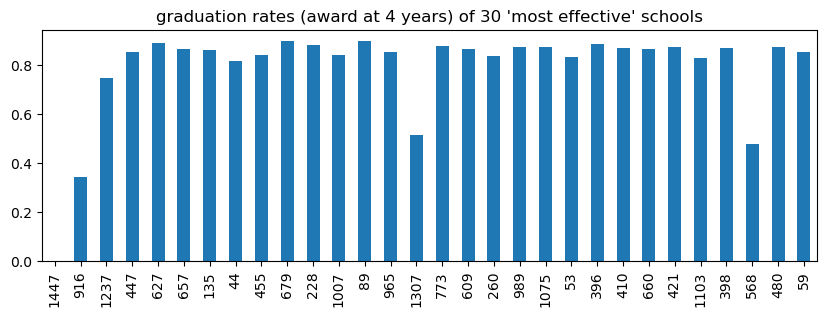

In [148]:
ax=data_with_level_sorted.head(30)['omawdp4'].plot(
     y='omawdp4', kind='bar', figsize=(10, 3))
ax.title.set_text("graduation rates (award at 4 years) of 30 'most effective' schools")

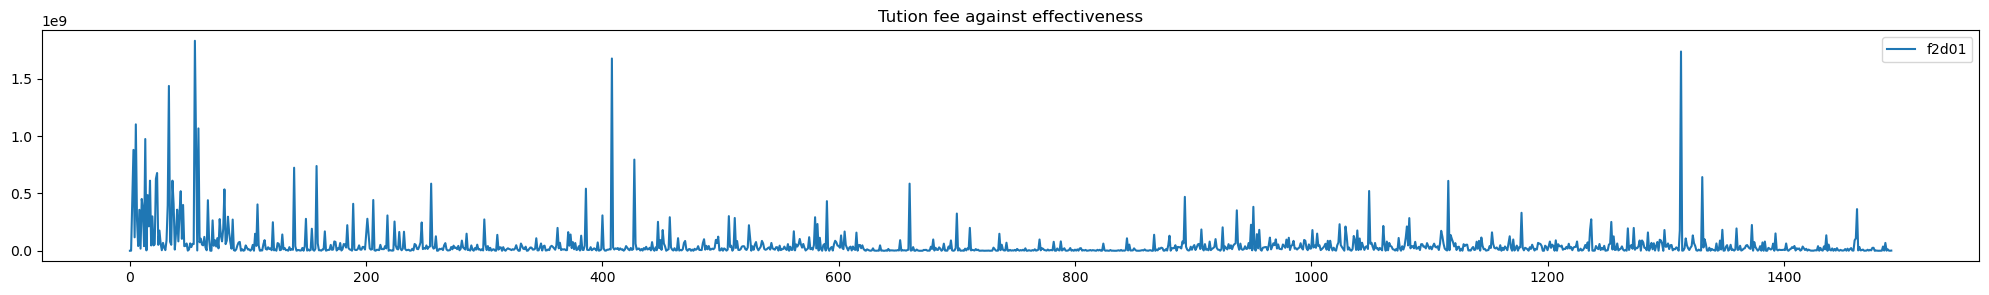

In [149]:
tuifees = pd.DataFrame(data_with_level_sorted['f2d01']).reset_index()


ax = tuifees.plot(
     y='f2d01', kind='line', figsize=(25, 3))
ax.title.set_text(
     "Tution fee against effectiveness")


In [150]:
y=t
for item in range(x):
    

IndentationError: expected an indented block (1562296696.py, line 3)